# Basic data preprocessing 
### load raw files -> generate clips -> compute features-> aggregate into a matrix of features and scores
** Pandas version required to load pickle files is 0.20.1 or greater **

* Try classifying symptom presence from "typing", "walking" and "finger-to-nose" 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt
import nolds

# from PreprocessFcns import gen_clips, powerspectra

%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
#---Pandas version required to load pickle files is 0.20.1 or greater---
pd.__version__

'0.20.3'

In [3]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
path = r'D:\CIS-PD Study\Subjects' #Windows remote path
#---------------------------------------------------------------------------------------------------------
folder_path = r'D:\CIS-PD Study' #generic Windows repo path

#Path where dictionary subject data is stored
#dict_path = 'D:\CIS-PD Study\Data_dict_noErr' #remote repo
dict_path = r'D:\CIS-PD Study\Data_dict'
# dict_path = '../Data_dict' # Mac local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

scores_path = r'D:\CIS-PD Study\Scores' #remote repo
# scores_path = '../Scores/' # Mac local path

#path where feature matrix is saved
features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
# features_path = '../FeatureMatrix' # Mac local path
# features_path = r'C:\Users\adai\Documents\FeatureMatrix' #Windows local path adai


In [4]:
complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])

complete_temp = complete
complete_temp.remove('MDS-UPDRS #11: Rest Tremor')


def process_annotations(path):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    del df['Value']
    
    df = df[(df.EventType != 'Testing Day')]
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    return df

## Helper fcns

In [5]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    timestamps = process_annotations(path)
    timestamps = fix_errors(SubID, timestamps)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Temporary fix for missing activities, added 10/10/2017 will remove once error functions are finished
    if SubID in ('1024', '1030', '1032'):
        complete_acts = complete_temp
    else:
        complete_acts = complete
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps


                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    

#extract clips for accelerometer and gyro data
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False,startTS=0,endTS=1):
    
    clip_data = {} #the dictionary with clips
    #params
    len_tol = 0.8   #% of the intended clipsize below which clip is not used

    for trial in act_dict[task].keys():
        clip_data[trial] = {}            

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #choose to create clips only on a fraction of the data (0<[startTS,endTS]<1)
            if (startTS > 0) | (endTS < 1):
                rawdata = rawdata.iloc[round(startTS*len(rawdata)):round(endTS*len(rawdata)),:]
                #reindex time (relative to start)
                idx = rawdata.index
                idx = idx-idx[0]
                rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
            clips = []
            for i in idx:
                c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                    clips.append(c)
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data


#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin
#if binavg is True it averages the PSD within bins to reduce PSD noise
def powerspectra(x,fm,fM,nbins=10,relative=False,binavg=True):
    
    #feature labels
    labels=[]
    s = np.linspace(fm,fM,nbins)
    lax = ['X','Y','Z']
    for l in lax:
        for i in s:
            labels.append('fft'+l+str(int(i)))
            
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
    
    #power spectra between fm-fM Hz
    bin1 = int(timestep*n*fm)
    bin2 = int(timestep*n*fM)
    bins = np.linspace(bin1,bin2,nbins,dtype=int)
#     print(bins/(round(timestep*n)))

    #average power spectra within bins
    if binavg:
        deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
        Pxxm = []
        for i in bins:
            start = int(max(i-deltab,bins[0]))
            end = int(min(i+deltab,bins[-1]))
            Pxxm.append(np.mean(Pxx.iloc[start:end,:].values,axis=0))            
        Pxxm = np.asarray(Pxxm)
        Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
        return Pxx, labels
    
    else:
        return Pxx.iloc[bins,:], labels


#extract features from both sensors (accel and gyro) for current clips and trials
#input: dictionary of clips from each subject
#output: feature matrix from all clips from given subject and scores for each clip
def feature_extraction(clip_data):
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','sEntX','sEntY','sENZ','sEnFFTX','sEnFFTy','sEnFFTz']
    
    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]
#                 print(rawdata.head(3))
                
                #extract features on current clip
                
                #Energy of signal on each axis
                E = np.asarray(np.sum(rawdata**2,axis=0))
                
                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)
            
                #Moments on each axis
                mean = np.asarray(np.mean(rawdata,axis=0))
                var = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)
                
                #Cross-correlation between axes pairs
                xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
                xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
                xcorr_peak_xy = np.max(xcorr_xy)
                xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

                xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
                xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
                xcorr_peak_xz = np.max(xcorr_xz)
                xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

                xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
                xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
                xcorr_peak_yz = np.max(xcorr_yz)
                xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

                #pack xcorr features
                xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
                xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
                
                #Power of FFT between 1-10 Hz
                Pxx,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
                xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
                xfft = np.reshape(xfft,(1,xfft.size)) #row vector
                xfft = xfft.reshape(-1)
                
                #sample entropy raw data and FFT 
                sH_raw = []; sH_fft = []
                for a in range(3):
                    x = rawdata.iloc[:,a]
                    n = len(x) #number of samples in clip
                    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
                    sH_raw.append(nolds.sampen(x)) #samp entr raw data
                    f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
                    sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

                #Assemble features in array
                X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,sH_raw,sH_fft,xfft))
#                 X = X.reshape(1,X.shape[0])
                features.append(X)
                    
            F = np.asarray(features) #feature matrix for all clips from current trial
            clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=features_list+fft_labels,dtype='float32')  
        
#     return clip_data #not necessary


#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
#input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter (highpass or lowpass).
def HPfilter(act_dict,task,loc,cutoff=0.75,ftype='highpass'):

    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_norm = cutoff/(0.5*Fs)
        b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt

        
#bandpass filter data (analysis of Tremor)
#input: Activity dictionary, min,max freq [Hz], task and sensor location to filter
def BPfilter(act_dict,task,loc,cutoff_low=3,cutoff_high=8,order=4):
    
    sensor = 'accel'
    for trial in act_dict[task].keys():
        rawdata = act_dict[task][trial][loc][sensor]
        idx = rawdata.index
        idx = idx-idx[0]
        rawdata.index = idx
        x = rawdata.values 
        Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate    
        #filter design
        cutoff_low_norm = cutoff_low/(0.5*Fs)
        cutoff_high_norm = cutoff_high/(0.5*Fs)
        b,a = butter(order,[cutoff_low_norm,cutoff_high_norm],btype='bandpass',analog=False)
        #filter data
        xfilt = filtfilt(b,a,x,axis=0)
        rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
        act_dict[task][trial][loc][sensor] = rawdatafilt
        


# Fix Error Functions

In [6]:
def fix_errors(participant, timestamps):
#input: 4 digit participant ID
# if debugFlag = 1, will execute merge function
#Output: ErrorList - A list of the errors needed to be fixed for the participant
#        timestamps - The dataFrame with the errors corrected for the participant
#        errordf - The dataFrame containing the remaining errors less the ones just fixed

    participant = int(participant) #convert to int, input SubID is a str
    errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
    errPar = errordf[errordf['Participant'] == participant]
    errorActivity = (errPar['Activity'])
    error = errPar['Error']
    cycle = errPar['Cycle']
    day = errPar['Day']
    time = errPar['Time Adjusted (sec)']
    desc = errPar['Type']
    errorAndActivity = errPar[['Error','Activity']]
    
    # Hard coded relabel for one activity in Subject 1049's timestamps
    if participant == 1049:
        for i in range(0,len(timestamps)-1):
            row = timestamps.iloc[i]
        
            if timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair' and row['Start Timestamp (ms)'] == 1505757980933:
                timestamps.reset_index(inplace=True)
                #timestamps.set_value(i, 'EventType', 'Motor #6: Sit to Stand')
                #.set_value is deprecated as of pandas 21.0, .at used instead for label-based
                timestamps.at[i, 'EventType'] = 'Motor #6: Sit to Stand'
                timestamps.set_index('EventType', inplace=True)
    
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        if errDay == 'Day 2':
            if 'MDS' in errAct:
                errCycle = errCycle + 2
            elif 'Motor' in errAct:
                errCycle = errCycle + 5

        if errType == 'Merge':
#             if debugFlag == 1:
#                 timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
#             else:
#                 ; # do nothing
            timestamps = fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Late':
            timestamps = fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Early':
            timestamps = fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)

        elif errType == 'Duplicate':
            timestamps = fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant)

        elif errType == 'Split':
            timestamps = fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
            
    for a in range(0,len(error)):
        errAct = (errorActivity.iloc[a])
        errType = (error.iloc[a])
        errCycle = (cycle.iloc[a])
        errTime = (time.iloc[a])
        errDesc = (desc.iloc[a])
        errDay = (day.iloc[a])
        
        if errType == 'Absent':
            timestamps = fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay)
    
    
    tempappend = errordf.loc[errPar.index.values]
    #fixdf = fixdf.append(tempappend)
    errordf = errordf.drop(errPar.index.values)
    
    print('Subject ' + str(participant) + ' had ' + str(len(error)) + ' errors fixed.')

    return timestamps


def fix_late(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# subtracts time from the beginning or ending timestamp of the designated activity

    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
      
            if errType == 'End':
                startTime = startRow['Stop Timestamp (ms)']
                startTime = startTime - (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
        
            else:
                startTime = startRow['Start Timestamp (ms)']
                # print(startRow)
                # print(startTime)
                startTime = startTime - (errTime*1000)
                # print(errTime)
                # print(startTime)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
     
    return timestamps


def fix_early(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
# adds time to the beginning or ending timestamp of the designated activity
    for i in range(0,len(timestamps)-1):
        startRow = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            errorLocation = i
            
            if errType == 'End':
                startTime = startRow[1]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

            else:
                startTime = startRow[0]
                startTime = startTime + (errTime*1000)
                ii = timestamps.columns.get_loc('Start Timestamp (ms)')
                # timestamps.set_value(i,ii,startTime,takeable=True)
                timestamps.iat[i,ii] = startTime
                # set_value is deprecated as of pandas 21.0, .iat used instead for position-based

    return timestamps


def fix_merge(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-2):
        nextRow = timestamps.iloc[i+1]
        startRow = timestamps.iloc[i]

        if timestamps.index[i] == errAct and startRow['Cycle'] == errCycle:
            timeEnd = nextRow['Stop Timestamp (ms)']
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd,takeable=True)
            timestamps.iat[i,ii] = timeEnd
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            timestamps = pd.concat([timestamps.iloc[:(i+1)],timestamps.iloc[(i+2):]])

        timestamps.reset_index(inplace=True)
        timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
        timestamps.set_index('EventType',inplace=True)

    return timestamps

                

def fix_split(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):

    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timeStart1 = row['Start Timestamp (ms)']
            timeEnd2 = row['Stop Timestamp (ms)']
            timeChange = errTime
            timeEnd1 = timeStart1 + timeChange
            timeStart2 = timeEnd1
            idx = complete.index(errAct)
            ErrorActivity2 = complete[idx+1]
            ii = timestamps.columns.get_loc('Stop Timestamp (ms)')
            # timestamps.set_value(i,ii,timeEnd1,takeable=True)
            timestamps.iat[i,ii] = timeEnd1
            # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
            line = pd.DataFrame({"Start Timestamp (ms)":timeEnd1,"Stop Timestamp (ms)":timeEnd2,"Cycle":errCycle},index=[ErrorActivity2])
            timestamps = pd.concat([timestamps.iloc[:(i+1)],line,timestamps.iloc[(i+1):]])
            
            timestamps.reset_index(inplace=True)
            colnames = timestamps.columns.tolist()
            colnames[colnames.index('index')] = 'EventType'
            timestamps.columns = colnames
            timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
            timestamps.set_index('EventType',inplace=True)
           
    return timestamps

            

def fix_duplicate(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay,participant):

    for i in range(0,len(timestamps)-2):
        row = timestamps.iloc[i]
        if participant == 1052 and timestamps.index[i] == 'MDS-UPDRS #6: Arising from Chair':
            if timestamps.index[i] == errAct and row['Cycle'] == errCycle+1:
                timestamps = pd.concat([timestamps.iloc[:(i)],timestamps.iloc[(i+1):]])
            
        elif timestamps.index[i] == errAct and row['Cycle'] == errCycle:
            timestamps = pd.concat([timestamps.iloc[:i],timestamps.iloc[(i+1):]])
            
    timestamps.reset_index(inplace=True)
    timestamps['Cycle'] = timestamps.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    timestamps.set_index('EventType',inplace=True)

    return timestamps

def fix_absent(timestamps,errType,errAct,errCycle,errTime,errDesc,errDay):
    
    for i in range(0,len(timestamps)-1):
        row = timestamps.iloc[i]
        
        if timestamps.index[i] == errAct and row['Cycle'] == errCycle:

            for j in range(i-1,len(timestamps)-1):
                row = timestamps.iloc[j]
                
                if timestamps.index[j] == errAct:
                    cyclenum = row['Cycle']
                    newCycle = cyclenum + 1
                    ii = timestamps.columns.get_loc('Cycle')
                    # timestamps.set_value(j,ii,newCycle,takeable=True)
                    timestamps.iat[j,ii] = newCycle
                    # set_value is deprecated as of pandas 21.0, .iat used instead for position-based
    
    return timestamps


In [7]:
errordf = pd.read_excel(os.path.join(folder_path, 'PD_errorWorkbook.xlsx'))
errordf

,Participant,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
0,1004,MDS-UPDRS #9: Postural Hand Tremor,1.0,Split,Day 1,5.0,NaN
1,1004,MDS-UPDRS #10: Kinetic Hand Tremor,1.0,Split Into,Day 1,NaN,NaN
2,1004,Motor #4: Finger to Nose,1.0,Merge,Day 1,NaN,NaN
3,1004,Motor #4: Finger to Nose,2.0,Merge,Day 1,NaN,NaN
4,1004,MDS-UPDRS #6: Arising from Chair,2.0,Absent,Day 1,NaN,Not tested
5,1004,MDS-UPDRS #11: Rest Tremor,2.0,Absent,Day 1,NaN,Not tested
6,1004,Motor #5: Alternating Hand Movements,4.0,Merge,Day 1,NaN,NaN
7,1016,MDS-UPDRS #8: Postural Stability,1.0,Early,Day 1,20.0,Start
8,1016,MDS-UPDRS #11: Rest Tremor,1.0,Early,Day 1,5.0,Start
9,1016,MDS-UPDRS #3: Pronation-Supination,1.0,Duplicate,Day 2,NaN,NaN


## Create dictionaries from sensor data from all the subjects

In [8]:
os.listdir(dict_path)

[]

In [9]:
#all subj data files in repository
d = os.listdir(path)
f = [filename[0:4] for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd] #ignore FX at end
print(list(set(f) - set(fd)))

#errors temporarily resolved 10/10/2017, will update later
# f.remove('1030')
# f.remove('1032')
# f.remove('1024')
# f.remove('1052')

['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1038', '1044', '1046', '1047', '1049', '1051', '1052']
['1038', '1044', '1020', '1016', '1019', '1032', '1030', '1051', '1024', '1046', '1004', '1047', '1018', '1049', '1052', '1029']


In [10]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print('Loading Subject ' + SubID + ' Data...')
    act_dict, timestamps = extract_data(SubID, os.path.join(path, SubID))
    print('Extract data complete.')
    #save dict to Pickle file
    #filename = dict_path+'\\'+SubID + 'dict.pkl'
    filename = os.path.join(dict_path, SubID + 'dict.pkl')
    print(filename)
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print(filename + ' ' + 'File Saved\n')

Loading Subject 1038 Data...
Subject 1038 had 4 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1038dict.pkl
D:\CIS-PD Study\Data_dict\1038dict.pkl File Saved

Loading Subject 1044 Data...
Subject 1044 had 3 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1044dict.pkl
D:\CIS-PD Study\Data_dict\1044dict.pkl File Saved

Loading Subject 1020 Data...
Subject 1020 had 5 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1020dict.pkl
D:\CIS-PD Study\Data_dict\1020dict.pkl File Saved

Loading Subject 1016 Data...
Subject 1016 had 5 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1016dict.pkl
D:\CIS-PD Study\Data_dict\1016dict.pkl File Saved

Loading Subject 1019 Data...
Subject 1019 had 3 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1019dict.pkl
D:\CIS-PD Study\Data_dict\1019dict.pkl File Saved

Loading Subject 1032 Data...
Subject 1032 had 9 errors fixed.
Extract data complete.
D:\CIS-PD Study\Data_dict\1032dict.pkl
D

## Explore features from individual subject 

In [11]:
# 1004 Merge Data
SubID = '1004'
debugPath = os.path.join(path, SubID)
# act_dict_noErr, timestamps_noErr = extract_data(int(SubID), debugPath, 0)
act_dict, timestamps = extract_data(int(SubID), debugPath)

Subject 1004 had 7 errors fixed.


In [12]:
#timestamps_noErr.loc['Motor #4: Finger to Nose']

In [13]:
timestamps.loc['Motor #4: Finger to Nose']

,Cycle,Start Timestamp (ms),Stop Timestamp (ms)
EventType,,,
Motor #4: Finger to Nose,1,1.499435e+12,1499435010276
Motor #4: Finger to Nose,2,1.499438e+12,1499437702483
Motor #4: Finger to Nose,3,1.499440e+12,1499440080993
Motor #4: Finger to Nose,4,1.499442e+12,1499441944961
Motor #4: Finger to Nose,5,1.499443e+12,1499443509237
Motor #4: Finger to Nose,6,1.499445e+12,1499444987849
Motor #4: Finger to Nose,7,1.500386e+12,1500386196754


In [14]:
#timestamps_noErr.loc['Motor #5: Alternating Hand Movements']

In [15]:
timestamps.loc['Motor #5: Alternating Hand Movements']

,Cycle,Start Timestamp (ms),Stop Timestamp (ms)
EventType,,,
Motor #5: Alternating Hand Movements,1,1.499435e+12,1499435097295
Motor #5: Alternating Hand Movements,2,1.499438e+12,1499437782996
Motor #5: Alternating Hand Movements,3,1.499440e+12,1499440164574
Motor #5: Alternating Hand Movements,4,1.499442e+12,1499442022084
Motor #5: Alternating Hand Movements,5,1.499444e+12,1499443582974
Motor #5: Alternating Hand Movements,6,1.499445e+12,1499445057742
Motor #5: Alternating Hand Movements,7,1.500386e+12,1500386238203


In [16]:
# 1018 Merge Data
SubID2 = '1018'
debugPath2 = os.path.join(path, SubID2)
# act_dict2_noErr, timestamps2_noErr = extract_data(int(SubID2), debugPath2, 0)
act_dict2, timestamps2 = extract_data(int(SubID2), debugPath2)

Subject 1018 had 2 errors fixed.


In [17]:
#timestamps2_noErr.loc['Motor #11: Organizing Folder']

In [18]:
timestamps2.loc['Motor #11: Organizing Folder']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #11: Organizing Folder,1500040514337,1500040564611,1
Motor #11: Organizing Folder,1500043372310,1500043411877,2
Motor #11: Organizing Folder,1500045224071,1500045285376,3
Motor #11: Organizing Folder,1500046707449,1500046754068,4
Motor #11: Organizing Folder,1500048422867,1500048469595,5
Motor #11: Organizing Folder,1500050552822,1500050606825,6
Motor #11: Organizing Folder,1501596937438,1501596981483,7


In [19]:
# 1032 Merge Data
SubID3 = '1049'
debugPath3 = os.path.join(path, SubID3)
# act_dict3_noErr, timestamps3_noErr = extract_data(int(SubID3), debugPath3, 0)
act_dict3, timestamps3 = extract_data(int(SubID3), debugPath3)

Subject 1049 had 8 errors fixed.


In [20]:
timestamps3

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #1: Finger Tapping,1504625987122,1504626012177,1
MDS-UPDRS #2: Hand Movements,1504626015643,1504626030238,1
MDS-UPDRS #3: Pronation-Supination,1504626033659,1504626047506,1
MDS-UPDRS #4: Toe Tapping,1504626051463,1504626069986,1
MDS-UPDRS #5: Leg Agility,1504626076575,1504626091702,1
MDS-UPDRS #6: Arising from Chair,1504626094805,1504626102728,2
MDS-UPDRS #7: Gait,1504626114678,1504626128326,1
MDS-UPDRS #8: Postural Stability,1504626144291,1504626161560,1
MDS-UPDRS #9: Postural Hand Tremor,1504626187039,1504626190126,1


In [21]:
timestamps3#.loc['Motor #5: Alternating Hand Movements']
SubID3 = '1049'
pd.options.display.max_rows = 999
Path = os.path.join(path, SubID3)
timestamps = process_annotations(Path)
timestamps


,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #1: Finger Tapping,1504625987122,1504626012177,1
MDS-UPDRS #2: Hand Movements,1504626015643,1504626030238,1
MDS-UPDRS #3: Pronation-Supination,1504626033659,1504626047506,1
MDS-UPDRS #4: Toe Tapping,1504626051463,1504626069986,1
MDS-UPDRS #5: Leg Agility,1504626076575,1504626091702,1
MDS-UPDRS #6: Arising from Chair,1504626094805,1504626102728,1
MDS-UPDRS #7: Gait,1504626114678,1504626128326,1
MDS-UPDRS #8: Postural Stability,1504626144291,1504626161560,1
MDS-UPDRS #9: Postural Hand Tremor,1504626187039,1504626190126,1


In [22]:
# 1046 Merge Data
SubID4 = '1046'
debugPath4 = os.path.join(path, SubID4)
# act_dict4_noErr, timestamps4_noErr = extract_data(int(SubID4), debugPath4, 0)
act_dict4, timestamps4 = extract_data(int(SubID4), debugPath4)

Subject 1046 had 8 errors fixed.


In [23]:
#timestamps4_noErr.loc['Motor #5: Alternating Hand Movements']

In [24]:
timestamps4.loc['Motor #5: Alternating Hand Movements']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #5: Alternating Hand Movements,1505918922988,1505918964452,1
Motor #5: Alternating Hand Movements,1505921739358,1505921776398,2
Motor #5: Alternating Hand Movements,1505924030217,1505924075245,3
Motor #5: Alternating Hand Movements,1505925945489,1505925979799,4
Motor #5: Alternating Hand Movements,1505927181527,1505927218828,5
Motor #5: Alternating Hand Movements,1505927906828,1505927941768,6
Motor #5: Alternating Hand Movements,1507135126633,1507135163595,7


In [25]:
# 1038 Merge Data
SubID5 = '1038'
debugPath5 = os.path.join(path, SubID5)
# act_dict5_noErr, timestamps5_noErr = extract_data(int(SubID5), debugPath5, 0)
act_dict5, timestamps5 = extract_data(int(SubID5), debugPath5)

Subject 1038 had 4 errors fixed.


In [26]:
#timestamps5_noErr.loc['Motor #12: Folding Towels']

In [27]:
timestamps5.loc['Motor #12: Folding Towels']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #12: Folding Towels,1501788809473,1501788870160,1
Motor #12: Folding Towels,1501790688039,1501790739727,2
Motor #12: Folding Towels,1501792408156,1501792459823,3
Motor #12: Folding Towels,1501793985396,1501794038377,4
Motor #12: Folding Towels,1501794890165,1501794956035,5
Motor #12: Folding Towels,1501795716832,1501795754924,6
Motor #12: Folding Towels,1507743777459,1507743848625,7


In [28]:
#load Pickle file dict
subj = 1004
#f = open(dict_path+'/'+str(subj)+'dict.pkl','rb')
f = open(os.path.join(dict_path, str(subj) + 'dict.pkl'), 'rb')
act_dict = pickle.load(f)
f.close()

In [29]:
#choose task, trials(visits) and sensor location
# task = 'Motor #8: Typing on a Computer'
task = 'Motor #5: Alternating Hand Movements'

loc = 'dorsal_hand_left'
# loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'
sensor = 'accel'
trial = 0

In [30]:
len(act_dict[task].keys())

7

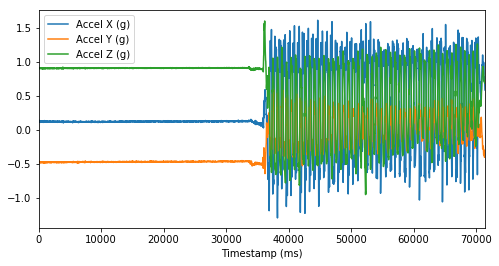

In [31]:
rawdata = act_dict[task][trial][loc][sensor]
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.plot(figsize=(8,4))

## HP Filter raw accelerometer data

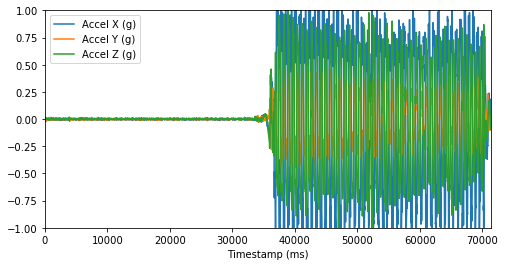

In [32]:
loc = 'dorsal_hand_left'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

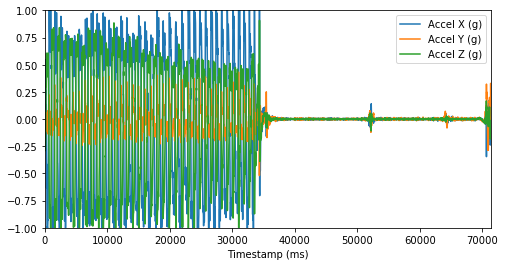

In [33]:
loc = 'dorsal_hand_right'
HPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

## BP filter (3-8 Hz) for tremor detection

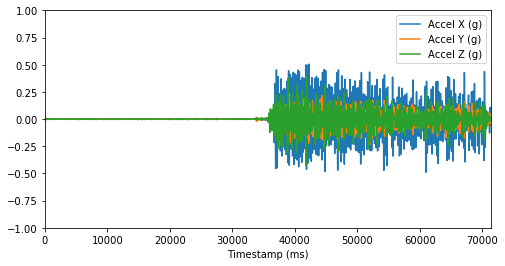

In [34]:
loc = 'dorsal_hand_left'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])

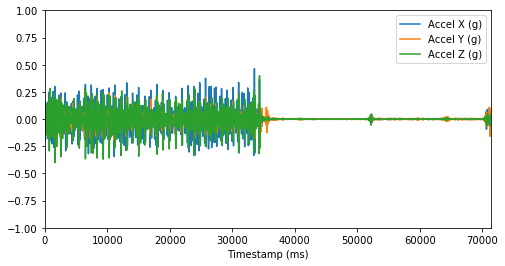

In [35]:
loc = 'dorsal_hand_right'
BPfilter(act_dict,task=task,loc=loc)
act_dict[task][0][loc][sensor].plot(figsize=(8,4))
ax = plt.ylim([-1,1])